# ispace 日足

In [1]:
import sys
sys.path.append('..')

In [2]:
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [3]:
pattern = re.compile(r'(.+)\.T')

symbol = '9348.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-09-13 00:00:00+09:00,745.0,761.0,731.0,731.0,1926400,0.0,0.0
2024-09-17 00:00:00+09:00,728.0,742.0,711.0,717.0,682100,0.0,0.0
2024-09-18 00:00:00+09:00,726.0,727.0,699.0,700.0,535500,0.0,0.0
2024-09-19 00:00:00+09:00,723.0,751.0,709.0,724.0,1502200,0.0,0.0
2024-09-20 00:00:00+09:00,724.0,733.0,719.0,731.0,646500,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-07 00:00:00+09:00,655.0,667.0,645.0,645.0,1262800,0.0,0.0
2025-03-10 00:00:00+09:00,661.0,662.0,643.0,654.0,804000,0.0,0.0
2025-03-11 00:00:00+09:00,640.0,652.0,629.0,648.0,1259600,0.0,0.0


## 日足チャートとパラボリック SAR

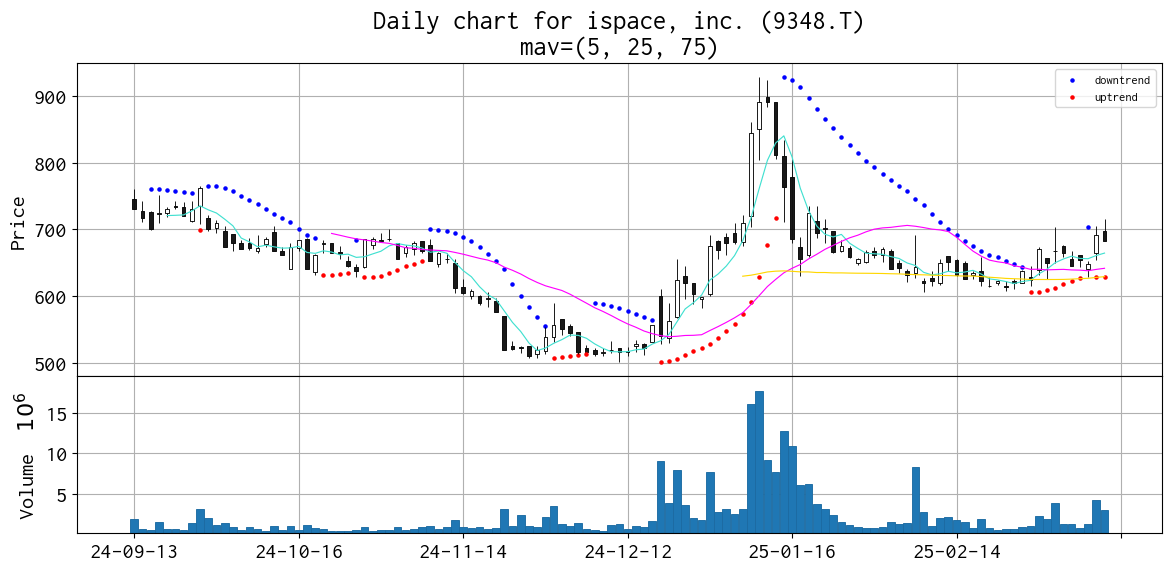

In [4]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax[0]
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax[0]
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=ax[1],
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)

try:
    ax[0].set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax[0].set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax[0].legend(loc='best', fontsize=9)

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [5]:
df.tail(2)['Close']

Date
2025-03-12 00:00:00+09:00    692.0
2025-03-13 00:00:00+09:00    683.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2025-02-28 00:00:00+09:00     NaN
2025-03-03 00:00:00+09:00    44.0
Name: Close, dtype: float64

In [6]:
df['Close'].rolling(5).mean().tail(2)

Date
2025-02-28 00:00:00+09:00    623.6
2025-03-03 00:00:00+09:00    632.6
Name: Close, dtype: float64

In [7]:
df['Close'].rolling(25).mean().tail(2)

Date
2025-02-28 00:00:00+09:00    640.08
2025-03-03 00:00:00+09:00    640.16
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(75).mean().tail(2)

Date
2025-02-28 00:00:00+09:00    624.826667
2025-03-03 00:00:00+09:00    624.840000
Name: Close, dtype: float64